In [5]:
%matplotlib inline

import gymnasium
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = BlackjackEnv()

In [7]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A=np.ones(nA,dtype=float)*epsilon/nA
        best_action=np.argmax(Q[observation])
        A[best_action]+=1-epsilon
        return A
    return policy_fn

In [10]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gymnasium environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    for i_episode in range(1, num_episodes + 1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        episode = []
        state = env.reset()
        while True:
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state


        sa_in_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in sa_in_episode:
            first_occurrence_idx = next(i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(episode[first_occurrence_idx:])])
            returns_sum[(state, action)] += G
            returns_count[(state, action)] += 1.0
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]



    
    return Q, policy

In [14]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

In [52]:
def get_action(state):
    action_values=Q[state]
    action=np.argmax(np.abs(action_values))
    if action==0:
        return "hit"
    if action==1:
        return"stick"

 #Enter the current state to get an action
state=(10,8,False)
print(get_action(state))


hit


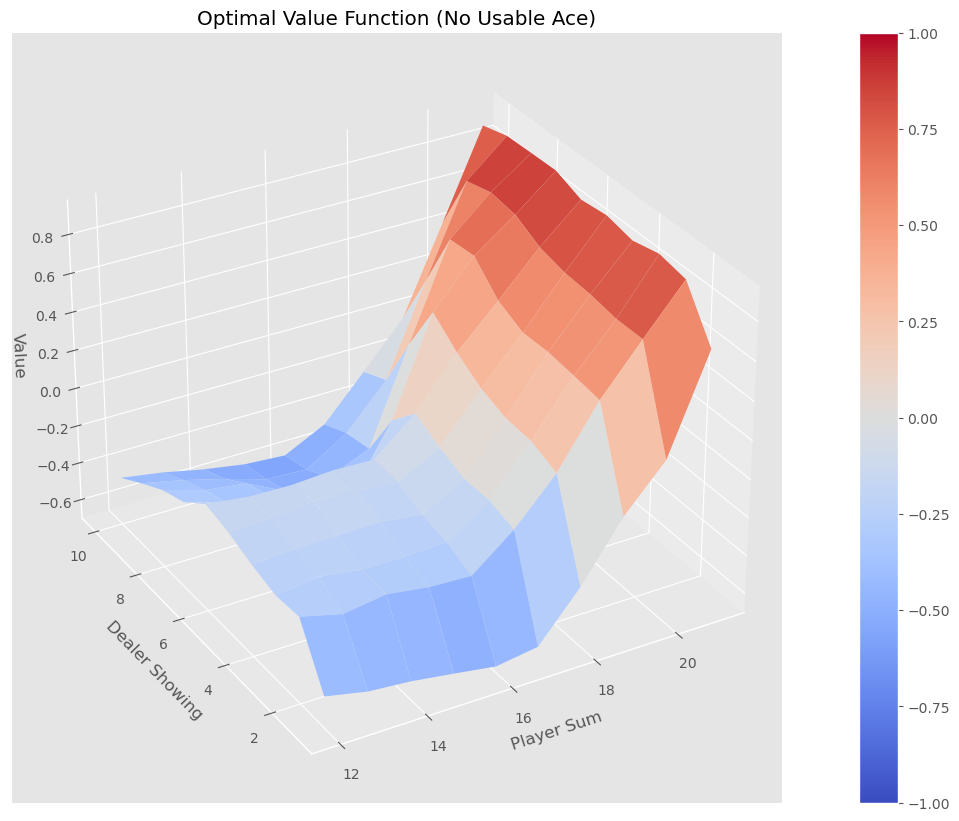

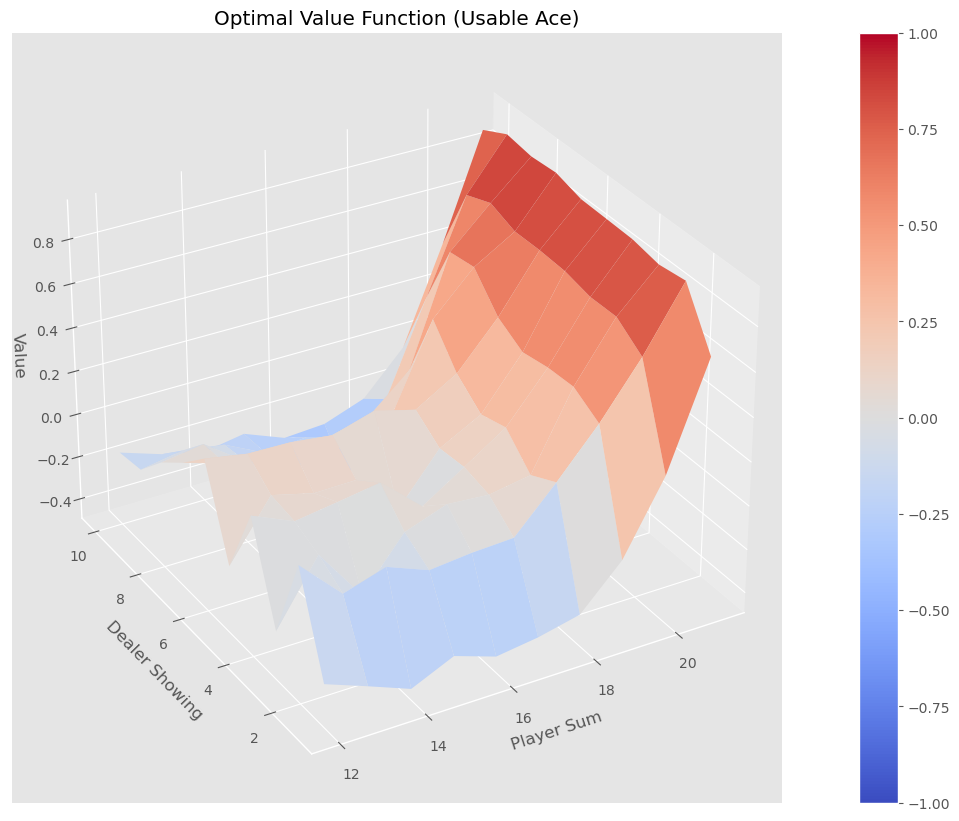

In [11]:

V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")